### Notebook for Vincent to create visualization / test code 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import clustering as cl
import util
import healpy as hp
import importlib as imp
from collections import defaultdict
import seaborn as sns 
from time import time
import visual

%matplotlib inline 

In [3]:
# Global parameters
gs = [0.4]
gdots = [-0.004, -0.002, 0.0, 0.002, 0.004]
g_gdots = [(x,y) for x in gs for y in gdots]

nside=8
n = -14
dt=15.0
cr=0.00124
pixels=range(hp.nside2npix(nside))

train_path = 'demo_train/UnnObs_Training_1_line_A_ec_labelled_2457308.5_pm15.0_r2.5.trans'
itf_path = 'demo_itf/itf_new_1_line_ec_2457308.5_pm15.0_r2.5.trans'


In [5]:
tr_results, tr_clust_ids = cl.find_clusters([281], train_path, util.lunation_center(n), g_gdots=g_gdots,dt=dt,rad=cr)

Starting run...
100%

Run finished!


In [8]:
res_dict = cl.get_res_dict(train_path,[281],nside,n)[281]

In [11]:
agg_dict = defaultdict(list)
for k,v in tr_clust_ids.items():
    # k is the tracklet id, v is the cluster id 
    if res_dict[k]!=[]:
        agg_dict[v].append([tuple([k]+list(i)) for i in res_dict[k]])

running Nelder-Mead
running Powell
running CG
running BFGS
running L-BFGS-B
running TNC
running COBYLA
running SLSQP


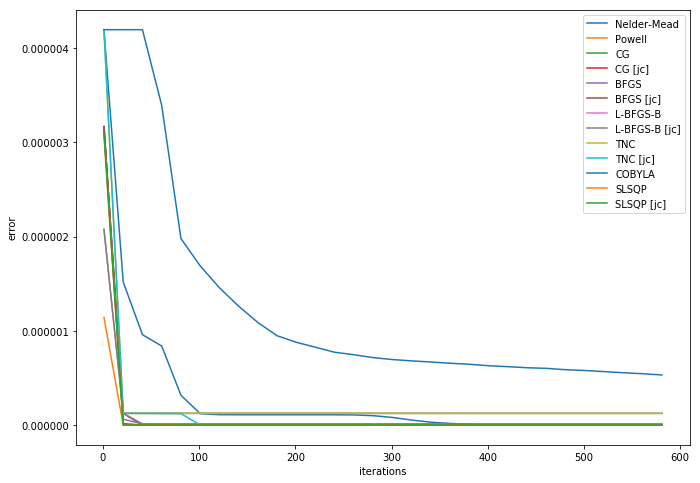

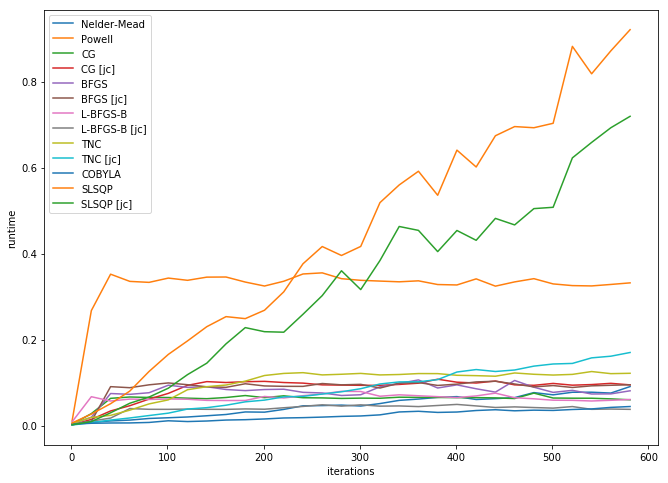

In [13]:
g,gdot = 0.4,0.0
idx = 2360
cl = imp.reload(cl)

import time

#special requirements:
#Hessian for Newton-CG
#Jacobian AND Hessian for dogleg
#Jacobian AND Hessian for trust-ncg

legend = []
solvers = ['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP']
plt.figure(1, figsize = (11,8))
plt.figure(2, figsize = (11,8))
for solver in solvers:
    print('running ' + solver)
    
    for use_jc in [False, True]:
        if use_jc and (solver=='Nelder-Mead' or solver=='Powell' or solver=='COBYLA'): continue #these solvers can not make use of the jacobian
        if not use_jc and (solver=='dogleg' or solver=='trust-ncg' or solver=='Newton-CG'): continue #these solvers explicitly require jacobians, so skip those
        yvals = []
        yvals_time = []
        xrange = range(1,600,20)
        for max_iter in xrange:
            start = time.clock()
            returns = cl.full_fit_t_loss(util.lunation_center(n), g, gdot, agg_dict[idx], details=True,  method=solver, force_itercount=max_iter, use_jacobian=use_jc)
            time_elapsed = time.clock()-start

            yvals_time.append(time_elapsed)
            
            params = returns[0]
            loss_val = returns[1]
            chisq = returns[2]
            chisq_arr = returns[3]

            iters = returns[4]
            num_evals = returns[5]
            num_evals_j = returns[6]
            num_evals_h = returns[7]
            #print('solver ' + str(solver) + ": loss = " + str(loss_val) + ', iters = ' + str(iters) + ', num_evals = ' + str(num_evals))
            yvals.append(loss_val)
           
        res = plt.figure(1)
        res = plt.plot(xrange, yvals)
        res = plt.figure(2)
        res = plt.plot(xrange, yvals_time)
        legend.append(solver + (' [jc]' if use_jc else ''))
        #break
    
res = plt.figure(1)
res = plt.legend(legend)
res = plt.xlabel('iterations')
res = plt.ylabel('error')

res = plt.figure(2)
res = plt.legend(legend)
res = plt.xlabel('iterations')
res = plt.ylabel('runtime')